# Inital setup

In [1]:
from iuvs import io
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

## loading summary file that I previously created by scanning through L1A darks.

In [2]:
import pandas as pd
df = pd.read_hdf('/home/klay6683/l1a_dark_stats.h5','df')

These are the columns I have available in this dataset:

In [3]:
df.columns

Index(['AVERAGE', 'BIN_SHIFT', 'BIN_SHIFT_DIR', 'BIN_TBL', 'BIN_TYPE', 'BIN_X_ROW', 'BIN_Y_ROW', 'BITPIX', 'BLANK', 'CADENCE', 'CAPTURE', 'CASE_TEMP', 'CHECKSUM', 'DATA_COMPRESSION', 'DET_TEMP', 'EXTEND', 'FILENAME', 'FUV_BAD_PIXEL_MASK', 'IMAGE_NUMBER', 'INT_TIME', 'LENGTH', 'MCP_GAIN', 'MCP_VOLT', 'MIRROR_POS', 'MIR_DEG', 'MODE', 'MUV_BAD_PIXEL_MASK', 'NAXIS', 'NAXIS1', 'NAXIS2', 'NAXIS3', 'NUMBER', 'N_FILL', 'OBS_ID', 'ON_CHIP_WINDOWING', 'PROCESS', 'SCAN_MODE', 'SCI_ERR_FLAGS', 'SCI_PKT_CKSUM', 'SCI_SEG_LENGTH', 'SCI_SEG_NUM', 'SCI_SEG_TOTAL', 'SET_TOTAL', 'SHUTTER_NUM', 'SHUTTER_OFF', 'SHUTTER_ON', 'SIMPLE', 'SPA_OFS', 'SPA_SIZE', 'SPE_OFS', 'SPE_SIZE', 'START_TIME', 'START_TIME__SUB', 'STEP_INT', 'STEP_NUM', 'STEP_SIZE', 'SW_VER', 'TEST_PATTERN', 'TIME_FLAG', 'XUV', 'dark_mean'], dtype='object')

# Correct mean DN for binning
When binning was applied, each pixel in the stored array carries the sum of the pixels that have been binned. Hence I have to correct the mean DN value for the applied binning.

In [4]:
def correct_mean_value(row):
    return row['SPE_SIZE'] * row['SPA_SIZE']
df['pixelsum'] = df.apply(correct_mean_value, axis=1)
df['corrected_mean'] = df.dark_mean / df.pixelsum

# Integration time correction
This is just to normalize for integration time to create DN/s. 

I also put here the time of the observation into the index and sort the data by time. This way, people that are more aware of the timeline could correlate special events to irregularities in the data.

In [5]:
df['DN_per_s'] = df.corrected_mean / (df.INT_TIME/1000)
df.index = df.FILENAME.map(lambda x: io.Filename(x).time)
df.index.name = 'Time'
df.sort_index(inplace=True)

# Different dark modes
Two different kinds of dark modes have been taken:

1. Using the shutter to block photon transport to the detector
2. Setting the MCP_Voltage to approx zero to avoid creating signal in the detector

Because of reduced reproducability for darks from mode 1, it was decided to use mode 2 for the future darks. I therefore filter out case 1 for now and set it to NAN.

Below one can see that most of the darks have been taken in mode 2 anyway:

In [6]:
df.MCP_VOLT.value_counts()

-1.830      9297
 846.558     324
 734.074     122
 746.030      11
 645.746      11
 622.322       2
 497.638       2
dtype: int64

In [7]:
import numpy as np
df[df.MCP_VOLT > 0] = np.nan

# Calibrate temperatures
I implemented my own DN_to_degC converter using the polynoms from our L1B pipeline.

In [8]:
from iuvs import calib
df.DET_TEMP = calib.iuvs_dn_to_temp(df.DET_TEMP, det_temp=True)
df.CASE_TEMP = calib.iuvs_dn_to_temp(df.CASE_TEMP, det_temp=False)

Checking how the stats look like for calibrated DET_TEMP

In [9]:
df.DET_TEMP.describe()

count    9297.000000
mean      -12.267575
std         6.597170
min       -24.105400
25%       -17.963600
50%       -11.447300
75%        -8.226600
max        11.397200
Name: DET_TEMP, dtype: float64

# Remaining trends in the DN_per_s
Now that I should have removed influences from INT_TIME, different methods of dark imaging and binning counts, I can focus on temperature effects. 

In [10]:
cols = 'DN_per_s CASE_TEMP DET_TEMP INT_TIME'.split()

This is a scatter matrix for the above chosen columns.

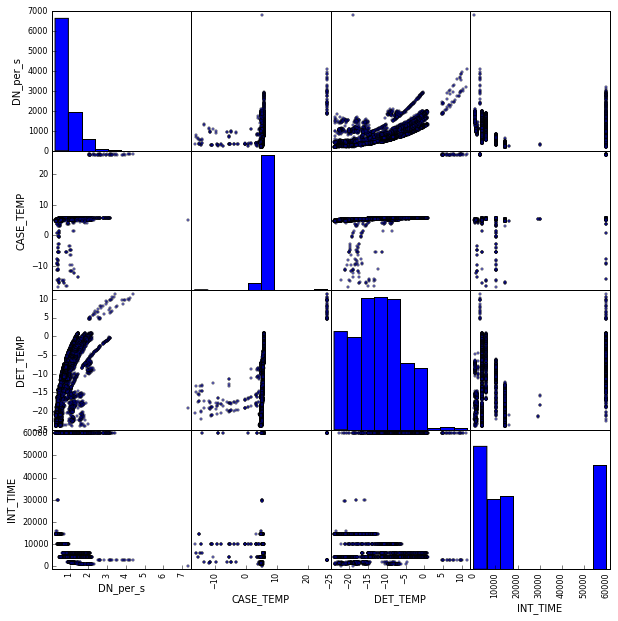

In [11]:
pd.scatter_matrix(df[cols], figsize=(10,10));

Note that the DN_per_s and DET_TEMP scatter plot still shows different `families`.
Because longer exposure times allow more cosmic rays to hit, it is to be expected that despite the correction for INT_TIME towards DN_per_s still shows differences per initial INT_TIME.

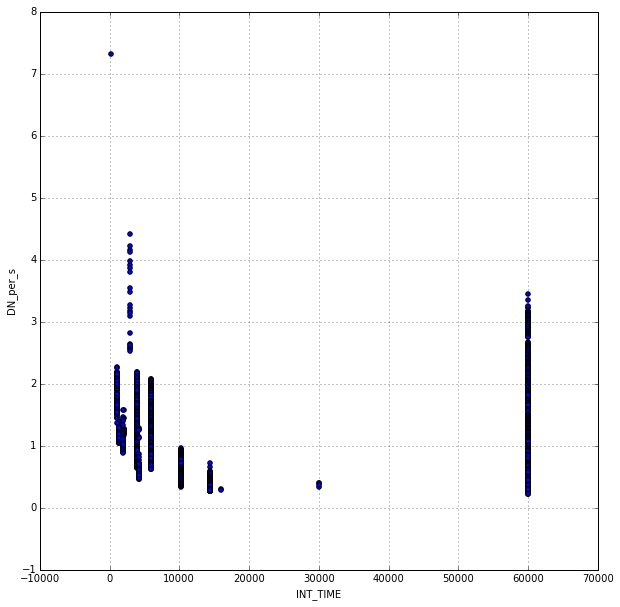

In [12]:
df.plot(x='INT_TIME', y='DN_per_s', kind='scatter')

Above we see that the longest INT_TIME shows the highest inherent scatter, most likely due to the CRs.

Let's see how the `DN_per_s` develop in general over time of observations and how that compares to `DET_TEMP`.

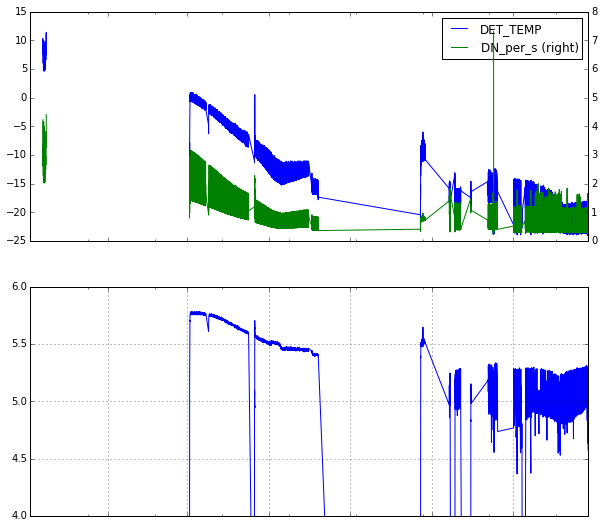

In [13]:
_, axes = subplots(nrows=2)
df[['DET_TEMP', 'DN_per_s']].plot(secondary_y='DN_per_s',ax=axes[0])
df.CASE_TEMP.plot(ax=axes[1], ylim=(4,6))

As previously known, we have a strong correlation between DET_TEMP and DN_per_s created.

Looking at a scatter plot, there seem to exist identifiable situations that create different relationships between `DET_TEMP` and `DN_per_s`:

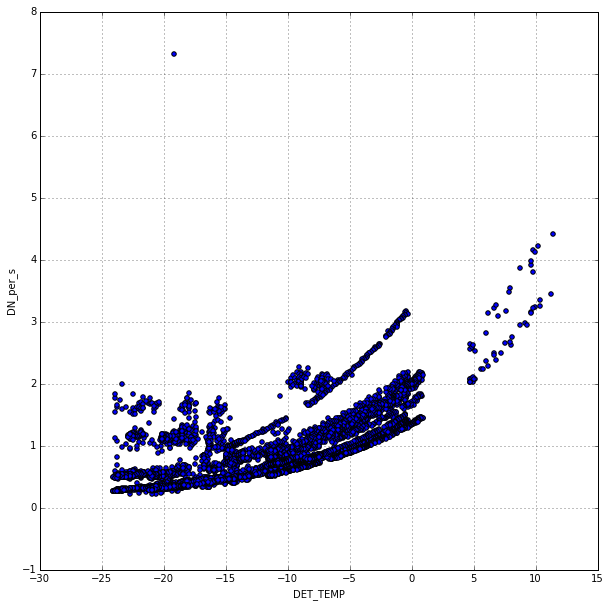

In [14]:
df.plot(x='DET_TEMP', y='DN_per_s',kind='scatter')

I was worried that I have to treat sets of dark images differently for some reason, so I filter out any data that has a valid NAXIS3 and look only at data that has no valid NAXIS3. (i.e. focusing on single dark images, which is the majority anyway, as seen here with the NaN entry).

In [15]:
df.NAXIS3.value_counts(dropna=False)

NaN     7337
 2      1963
 21      445
 226       5
 97        4
 49        4
 112       3
 104       2
 88        2
 60        2
 39        2
dtype: int64

In [16]:
subdf = df[df.NAXIS3.isnull()]

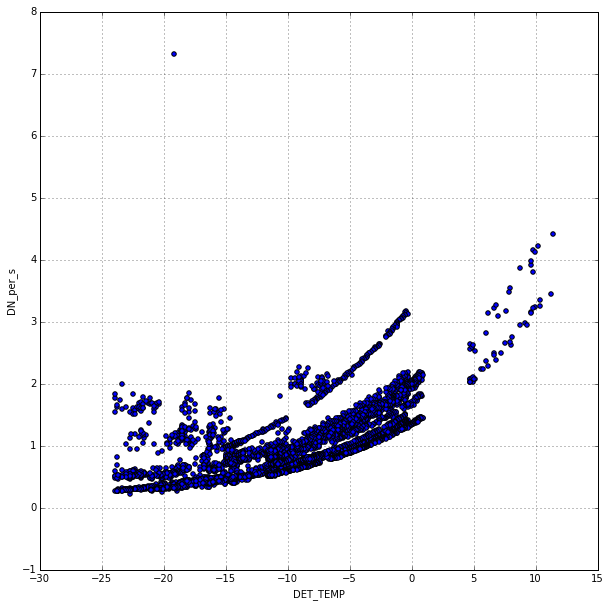

In [17]:
subdf.plot(x='DET_TEMP', y='DN_per_s', kind='scatter')

But the result looks the same, so this is no issue.
Nevertheless, to be sure I will use this subframe from now on.

## INT_TIME dependencies
As mentioned before, different integration times offer different probabilities for disturbant factors to happen. So let's focus on particular INT_TIMEs. Here's how the dark INT_TIMEs distribute over the L1A dataset.
One also has to divide the MUV and FUV data.

In [18]:
df.INT_TIME.value_counts()

60000    2620
14400    1831
10200    1754
4000     1063
4200      867
6000      518
1400      240
1000      221
1900      136
3000       22
2000       14
30000       4
29400       3
16000       2
200         2
dtype: int64

In [19]:
fuv = subdf[subdf.XUV=='FUV']
muv = subdf[subdf.XUV=='MUV']

Looping over a chosen set of INT_TIMEs to create the following overview plot, where things are separated for different INT_TIMES.
First, the MUV data.
### MUV DN_per_s vs DET_TEMP

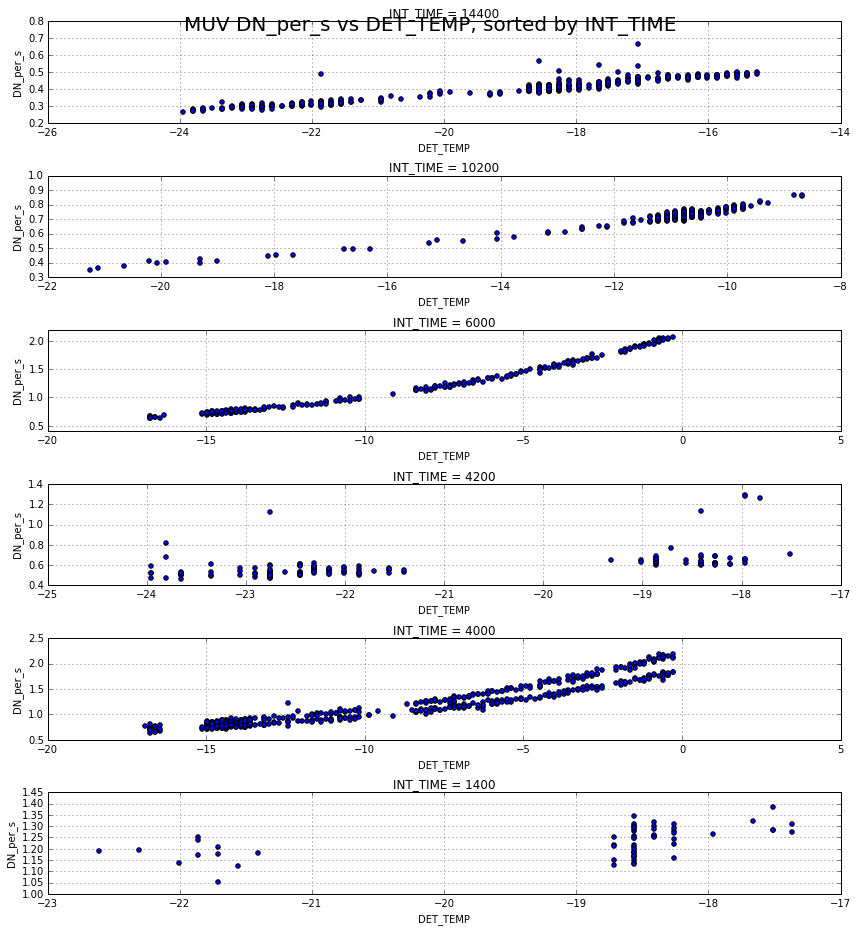

In [21]:
inttimes = [14400, 10200, 6000, 4200, 4000, 1400]
fig, axes = subplots(nrows=len(inttimes), figsize=(12,13))
for ax, inttime in zip(axes, inttimes):
    muv[muv.INT_TIME==inttime].plot(x='DET_TEMP', y='DN_per_s',kind='scatter', ax=ax, sharex=False)
    ax.set_title('INT_TIME = {}'.format(inttime))
fig.suptitle('MUV DN_per_s vs DET_TEMP, sorted by INT_TIME', fontsize=20)
fig.tight_layout()

### FUV DN_per_s vs DET_TEMP

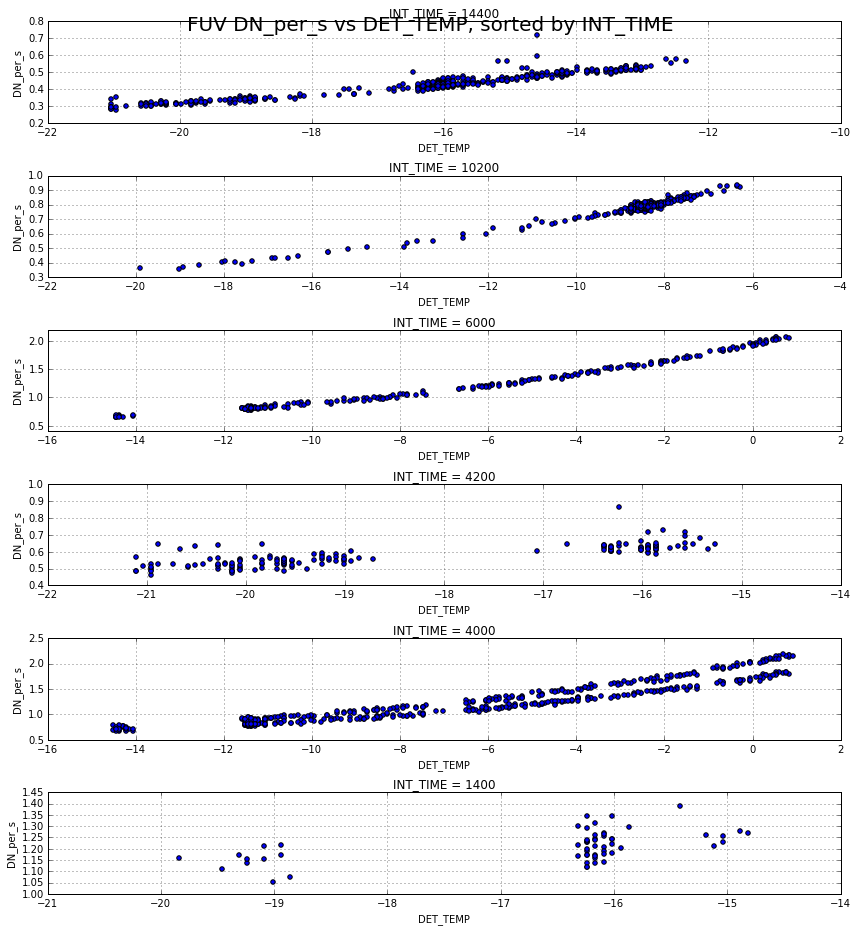

In [22]:
inttimes = [14400, 10200, 6000, 4200, 4000, 1400]
fig, axes = subplots(nrows=len(inttimes), figsize=(12,13))
for ax, inttime in zip(axes, inttimes):
    fuv[fuv.INT_TIME==inttime].plot(x='DET_TEMP', y='DN_per_s',kind='scatter', ax=ax, sharex=False)
    ax.set_title('INT_TIME = {}'.format(inttime))
fig.suptitle('FUV DN_per_s vs DET_TEMP, sorted by INT_TIME', fontsize=20)
fig.tight_layout()

Following the interesting consistent separation in families of scatter points, let's look at what the DET_TEMP does over time during these different INT_TIMES.

### MUV DET_TEMP over Time

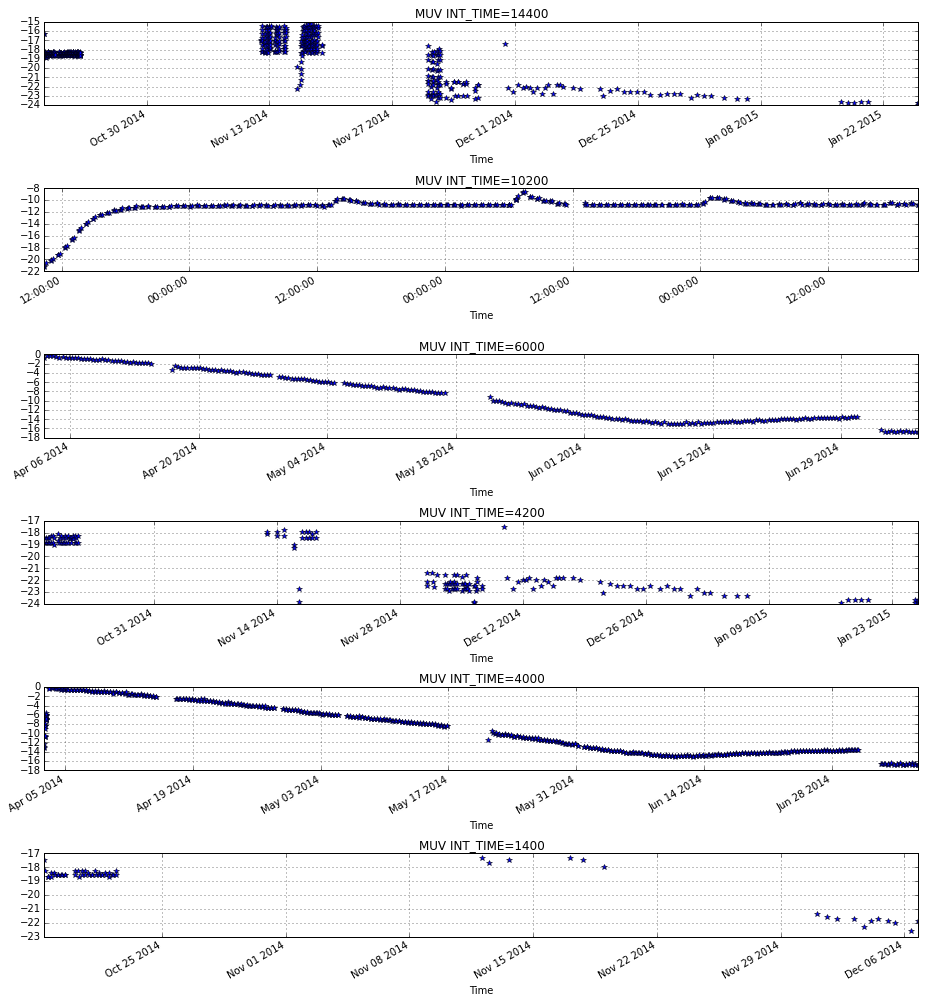

In [23]:
fig, axes = subplots(nrows=len(inttimes), figsize=(13,14))
for ax,inttime in zip(axes, inttimes):
    muv[muv.INT_TIME==inttime]['DET_TEMP'].plot(ax=ax, style='*', sharex=False)
    ax.set_title('MUV INT_TIME={}'.format(inttime))
fig.tight_layout()

### FUV DET_TEMP over TIME

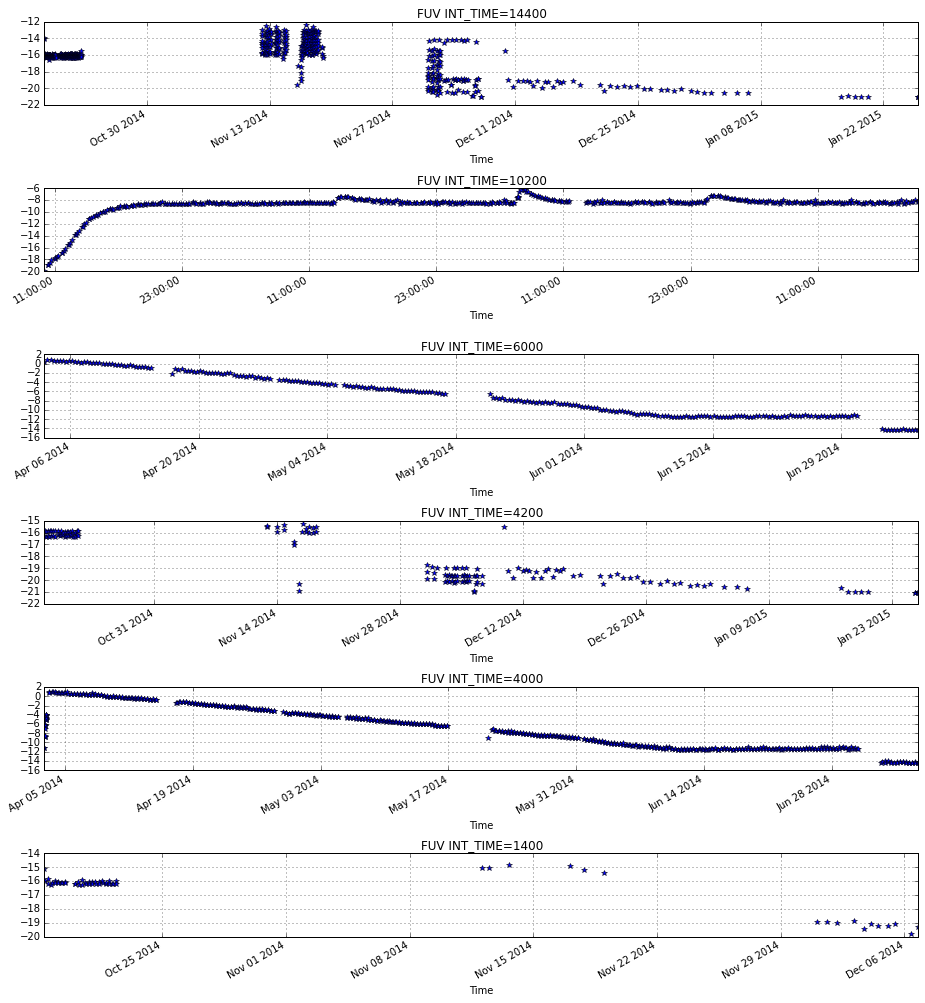

In [24]:
fig, axes = subplots(nrows=len(inttimes), figsize=(13,14))
for ax,inttime in zip(axes, inttimes):
    fuv[fuv.INT_TIME==inttime]['DET_TEMP'].plot(ax=ax, style='*', sharex=False)
    ax.set_title('FUV INT_TIME={}'.format(inttime))
fig.tight_layout()

Do we have some flip-flopping state the instrument is in, creating different modes of detector efficiency?